In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

**Intro**

The idea for this EDA came from the desire to buy a tablet on eBay. Specifically, I wanted to get answers for these questions: 
+ How much should I be paying for a tablet?
+ What is the average price of a tablet on eBay?
+ Is there a relationship between tablet price and seller feedback score? (if tablets cost more when sellers have higher feedback scores)

In [2]:
# imports
import pandas as pd
import json
import requests

In [3]:
# functions 
def get_oauth_configuration():
    with open('config.json') as config_file:
        json_conf = json.load(config_file)
    return json_conf

def call_limit(total_items):
    return int(total_items['total']/200) #200 is the return limit for each call

def get_post_code(item_location):
    try:
        return item_location['postalCode']
    except:
        return None

def get_country(item_location):
    try:
        return item_location['country']
    except:
        return None

def get_price(price):
    try:
        return price['value']
    except:
        return None
    
def get_initial_currency(price):
    try:
        return price['currency']
    except:
        return None
    
def get_feedback_score(seller):
    try:
        return seller['feedbackScore']
    except:
        return None
    
def get_seller_username(seller):
    try:
        return seller['username']
    except:
        return None

**Get access to eBay production servers**

To connnect to the eBay production servers, you will need to become an eBay Developers Program member and get OAuth Application Token. Please follow instructions [here](https://developer.ebay.com/api-docs/static/make-a-call.html).

In [4]:
# authorization configuration
json_conf = get_oauth_configuration()
oauth_key = "Bearer %s" % (json_conf['OAuth'])

** Collecting data from eBay production servers**

In [5]:
# user inputs, in case the analysis to be used for other products
search_item = "tablet" 
category_id = "171485"
country = "DE" # two digit country code
buying_option = "FIXED_PRICE" # or "AUCTION"

*user inputs:*
+ search_item = "tablet" 
+ category_id = "171485"
+ country = "DE" # two digit country code
+ buying_option = "FIXED_PRICE" # or "AUCTION"

For further configuration:
+ Detailed list of category IDs can be found [here](https://pages.ebay.com/sellerinformation/growing/categorychanges/computers-all.html)
+ Documentation on [URL parameters](https://developer.ebay.com/api-docs/buy/browse/resources/item_summary/methods/search) and [call field filters](https://developer.ebay.com/api-docs/buy/static/ref-buy-browse-filters.html#buyingOptions)

In [6]:
### initial query 
url = "https://api.ebay.com/buy/browse/v1/item_summary/search"

item_location_country = "itemLocationCountry:%s" %country
buying_option_query_string = "buyingOptions:{%s}" %buying_option

querystring = {"q":search_item,"category_ids":category_id,"filter":[item_location_country,
                                      buying_option_query_string],
               "limit":"200"}

headers = {
    'Authorization': oauth_key,
    'Cache-Control': "no-cache",
    'Postman-Token': "ea7eb33b-e3d5-489f-9647-df655f34e5cb"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

# parsing the response
item_text = dict(response.json())
item_summaries = item_text['itemSummaries']

# dataframe from the first result
items_df = pd.DataFrame.from_dict(item_summaries)
items_df = items_df[[
       'condition', 'conditionId', 'itemId', 'itemLocation',
       'itemWebUrl', 'price', 'seller', 
       'title']]

In [7]:
# call function to determine the number of times to call API
call_limit_number = call_limit(item_text)

# set the initial URL to fetch data from the next page
url_for_loop = item_text['next']

# for loop to fetch all available data for search item
for i in range(call_limit_number):
    try:
        response_next = requests.request("GET", url_for_loop, headers=headers, params=querystring)


        # parsing the response
        item_text_iteration = dict(response_next.json())
        item_summaries_iteration = item_text_iteration['itemSummaries']

        # dataframe from the first result
        items_iteration = pd.DataFrame.from_dict(item_summaries_iteration)
        items_iteration = items_iteration[[
           'condition', 'conditionId', 'itemId', 'itemLocation',
           'itemWebUrl', 'price', 'seller',
           'title']]
        
        # appending items_df
        items_df = items_df.append(items_iteration)

        # set the URL to fetch within the for loop for the next page
        url_for_loop = item_text_iteration['next']
    
    except:
        break

In [8]:
items_df.head(3)

,condition,conditionId,itemId,itemLocation,itemWebUrl,price,seller,title
0,Neu,1000,v1|263656865900|0,"{'postalCode': '73525', 'country': 'DE'}",https://www.ebay.com/itm/MICROSOFT-SURFACE-PRO...,"{'value': '142.11', 'currency': 'USD', 'conver...","{'username': 'microsoftler83', 'feedbackPercen...",MICROSOFT SURFACE PRO 4 WiFi 128GB TABLET PC I...
1,Used,3000,v1|263692832147|0,"{'postalCode': '10178', 'country': 'DE'}",https://www.ebay.com/itm/MINT-Barnes-Noble-Noo...,"{'value': '37.43', 'currency': 'USD', 'convert...","{'username': 'truc7de', 'feedbackPercentage': ...","MINT Barnes Noble Nook Tablet 7"" (Model Bnt..."
2,Vom Hersteller generalüberholt,2000,v1|372305712989|0,"{'postalCode': '37539', 'country': 'DE'}",https://www.ebay.com/itm/Archos-70C-Xenon-8-GB...,"{'value': '70.63', 'currency': 'USD', 'convert...","{'username': 'newborn1977', 'feedbackPercentag...",Archos 70C Xenon 8 GB Tablet Android Dual Core...


The resulting dataset needs to be cleaned before the analysis. Item location, price, and seller columns have nested structures (dictionaries).

** Data Cleaning **

In [9]:
# get initial info about dataframe
items_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149 entries, 0 to 148
Data columns (total 8 columns):
condition       1149 non-null object
conditionId     1149 non-null object
itemId          1149 non-null object
itemLocation    1149 non-null object
itemWebUrl      1149 non-null object
price           1149 non-null object
seller          1149 non-null object
title           1149 non-null object
dtypes: object(8)
memory usage: 80.8+ KB


The dataset has 1149 rows and 8 columns. 

In [10]:
# number of unique selling offerings
print("Unique items: ", items_df.itemId.nunique())

Unique items:  987


In [11]:
# droping duplicates
items_df.drop_duplicates(subset='itemId',inplace=True)
print('The shape of dataset after dropping dulplicates: ', items_df.shape)

The shape of dataset after dropping dulplicates:  (987, 8)


In [12]:
# applying functions to get rid of dictionaries in rows
items_df_clean = items_df.copy()

# location info
items_df_clean['post_code'] = items_df_clean.itemLocation.apply(get_post_code)
items_df_clean['country'] = items_df_clean.itemLocation.apply(get_country)
items_df_clean.drop('itemLocation', axis=1, inplace=True)

# price info
items_df_clean['price_value'] = items_df_clean.price.apply(get_price)
items_df_clean['currency'] = items_df_clean.price.apply(get_initial_currency)
items_df_clean.drop('price', axis=1, inplace=True)

# feedback score and seller info
items_df_clean['feedback_score'] = items_df_clean.seller.apply(get_feedback_score)
items_df_clean['seller_username'] = items_df_clean.seller.apply(get_seller_username)
items_df_clean.drop('seller', axis=1, inplace=True)

In [13]:
items_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 0 to 148
Data columns (total 11 columns):
condition          987 non-null object
conditionId        987 non-null object
itemId             987 non-null object
itemWebUrl         987 non-null object
title              987 non-null object
post_code          890 non-null object
country            987 non-null object
price_value        987 non-null object
currency           987 non-null object
feedback_score     987 non-null int64
seller_username    987 non-null object
dtypes: int64(1), object(10)
memory usage: 92.5+ KB


Note that data types of columns _postCode_, _conditionId_, _priceValue_ are non numeric. Therefore, these columns need to be transformed to numeric ones. 

In [14]:
#change the following columns to numeric dtype
items_df_clean[['conditionId', 'post_code','price_value', 
                'feedback_score']] = items_df_clean[['conditionId', 'post_code','price_value', 
                'feedback_score']].apply(pd.to_numeric, errors='coerse')

In [15]:
items_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 0 to 148
Data columns (total 11 columns):
condition          987 non-null object
conditionId        987 non-null int64
itemId             987 non-null object
itemWebUrl         987 non-null object
title              987 non-null object
post_code          890 non-null float64
country            987 non-null object
price_value        987 non-null float64
currency           987 non-null object
feedback_score     987 non-null int64
seller_username    987 non-null object
dtypes: float64(2), int64(2), object(7)
memory usage: 92.5+ KB


After tranformation, we have all columns in proper data types.

In [16]:
items_df_clean.head(3)

,condition,conditionId,itemId,itemWebUrl,title,post_code,country,price_value,currency,feedback_score,seller_username
0,Neu,1000,v1|263656865900|0,https://www.ebay.com/itm/MICROSOFT-SURFACE-PRO...,MICROSOFT SURFACE PRO 4 WiFi 128GB TABLET PC I...,73525.0,DE,142.11,USD,399,microsoftler83
1,Used,3000,v1|263692832147|0,https://www.ebay.com/itm/MINT-Barnes-Noble-Noo...,"MINT Barnes Noble Nook Tablet 7"" (Model Bnt...",10178.0,DE,37.43,USD,14760,truc7de
2,Vom Hersteller generalüberholt,2000,v1|372305712989|0,https://www.ebay.com/itm/Archos-70C-Xenon-8-GB...,Archos 70C Xenon 8 GB Tablet Android Dual Core...,37539.0,DE,70.63,USD,5515,newborn1977


The cleaned dataframe looks good. However, lets make sure that some details are matching: 
+ *country* should be DE (the analysis is only for DE) 
+ *currency* should be only USD to make it consistent (the initial EDA revealed that there are several currencies in the results)
+ *condition* should have no duplicates

In [17]:
print("available currencies: ", items_df_clean.currency.unique())
print("available countries: ", items_df_clean.country.unique())
print("available condition types: ", items_df_clean.condition.unique(), 
      "count: ", items_df_clean.condition.nunique())

available currencies:  ['USD']
available countries:  ['DE']
available condition types:  ['Neu' 'Used' 'Vom Hersteller generalüberholt' 'Gebraucht' 'New'
 'New other (see details)' 'Neu: Sonstige (siehe Artikelbeschreibung)'
 'Als Ersatzteil / defekt' 'New: Never Used'
 'Vom Verkäufer generalüberholt' 'Manufacturer refurbished' 'Nuovo'] count:  12


There are **12 different condition categores** in the data, however some of them have the same meanings:

+ _Manufacturer refurbished_ **=** _Vom Hersteller generalüberholt_
+ _New_ **=** _Neu_ **=** _Nuovo_
+ _Used_ **=** _Gebraucht_
+ _New other (see details)_ **=** _Neu: Sonstige (siehe Artikelbeschreibung)_

In [18]:
print("available conditionID types: ", items_df_clean.conditionId.unique())

available conditionID types:  [1000 3000 2000 1500 7000 2500]


In [22]:
print('Matching different categories with category IDs:\n')

items_df_clean.groupby(['condition','conditionId']).size().reset_index().rename(columns={0:'count'}).sort_values(by='conditionId')

Matching different categories with category IDs:



,condition,conditionId,count
3,Neu,1000,391
5,New,1000,18
8,Nuovo,1000,2
4,Neu: Sonstige (siehe Artikelbeschreibung),1500,157
6,New other (see details),1500,7
7,New: Never Used,1500,3
2,Manufacturer refurbished,2000,2
10,Vom Hersteller generalüberholt,2000,35
11,Vom Verkäufer generalüberholt,2500,30
1,Gebraucht,3000,317


From the table above, we can see that there are language differences in _condition_ column, however conditions are still assignable to unique condtion IDs that are languange independent. So, let's clean up the _condition_ column a bit.

In [31]:
#updating individual cell values
items_df_clean.loc[items_df_clean.conditionId==1000, ['condition']] = 'New'
items_df_clean.loc[items_df_clean.conditionId==1500, ['condition']] = 'New other (see details)'
items_df_clean.loc[items_df_clean.conditionId==2000, ['condition']] = 'Manufacturer refurbished'
items_df_clean.loc[items_df_clean.conditionId==2500, ['condition']] = 'Seller refurbished'
items_df_clean.loc[items_df_clean.conditionId==3000, ['condition']] = 'Used'
items_df_clean.loc[items_df_clean.conditionId==7000, ['condition']] = 'Spare part/defect'

#change condition dtype to categorical
items_df_clean.condition = pd.Categorical(items_df_clean.condition)

In [24]:
items_df_clean.groupby(['condition','conditionId']).size().reset_index().rename(columns={0:'count'}).sort_values(by='conditionId')

,condition,conditionId,count
1,New,1000,411
2,New other (see details),1500,167
0,Manufacturer refurbished,2000,37
3,Seller refurbished,2500,30
5,Used,3000,323
4,Spare part/defect,7000,19


Looks better now :)

**Analysis**

I want to buy a tablet on eEbay and it would be good to know how much the average price is.

In [25]:
items_df_clean.price_value.describe()

count     987.000000
mean      285.810091
std       290.248791
min         5.890000
25%       117.740000
50%       176.600000
75%       324.330000
max      2440.530000
Name: price_value, dtype: float64

The average price for a tablet is around 285USD and the maximum price is 2440USD (which is a lot for a tablet :))

Let's visualize the distribution of tablet prices

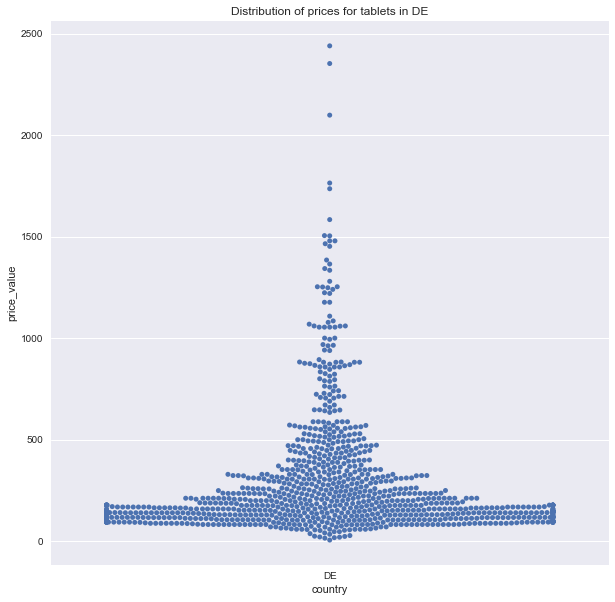

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

#plot cost distribution
plt.figure(figsize=(10,10))
sns.swarmplot(x='country', y='price_value', data=items_df_clean, orient='v')
plt.title('Distribution of prices for tablets in DE')
plt.show()

From the graph, we can see that most of the tablets cost below 500USD. So, paying 500USD or less would be good?
+ No fast conclusion, the data needs be explored more, lets look into the distribution of prices per condition category.

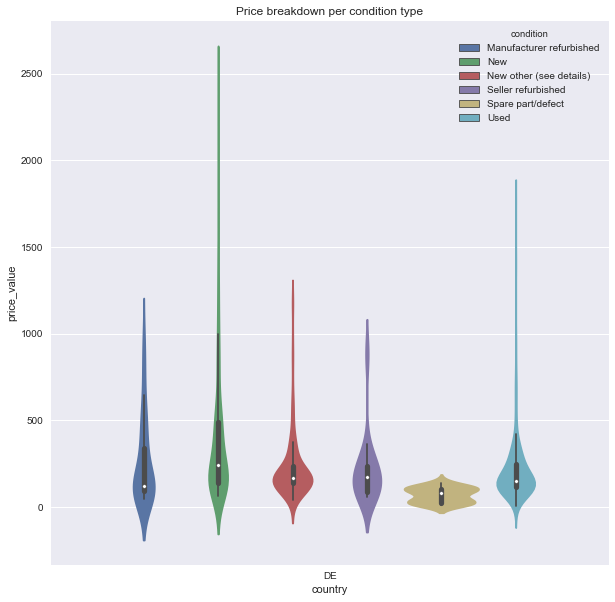

In [43]:
#plot cost distribution per condtion
plt.figure(figsize=(10,10))
sns.violinplot(x='country', y='price_value', data=items_df_clean, hue='condition',orient='v')
plt.title('Price breakdown per condition type')
plt.show()

From the graph above, we can see that prices of new tablets are distributed in the very long tail with the upper 75% of tablets costing below 500USD and the 50% (median) of tablets costing below 250USD. 

+ Therefore, I would personally consider it as a reasonable price to pay 250USD for a tablet.

little note here: the brand of tablet is not taken into consideration ;)

Now, I want to find out if there is any relationship between feeback score of the seller and the price.

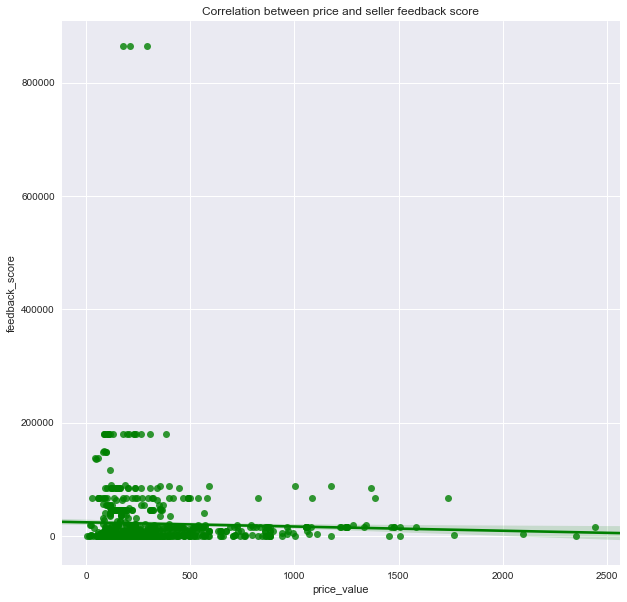

In [44]:
# Plot a linear regression between 'price' and 'feedback score'
plt.figure(figsize=(10,10))
sns.regplot(x='price_value', y='feedback_score', data=items_df_clean, color='green')
plt.title('Correlation between price and seller feedback score')
# Display the plot
plt.show()

Apparently, there is no correlation between feedback score and price. The sellers do not charge more as their feedback scores increase, which is good for buyers.

Let us have a look at cumulative distribution of feedback scores

In [64]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

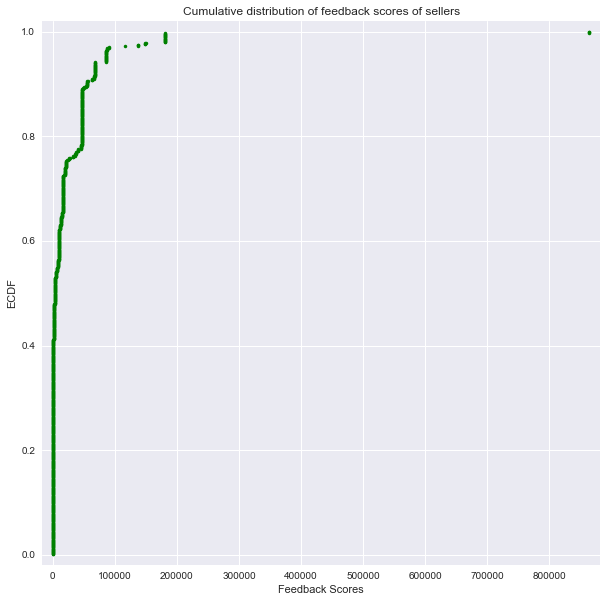

In [71]:
import numpy as np
# Compute ECDF for versicolor data: x_vers, y_vers# Compu 
x_vers, y_vers = ecdf(items_df_clean.feedback_score)

plt.figure(figsize=(10,10))
plt.plot(x_vers, y_vers, marker='.', linestyle='none', color='green')
plt.margins(0.02)

plt.xlabel('Feedback Scores')
plt.ylabel('ECDF')
plt.title('Cumulative distribution of feedback scores of sellers')

plt.show()

The CDF graph shows us that most of the tablet sellers (~97%) have feedback score of less than 100,000. Let us find out what are the seller usernames that have the highest feedback scores.

In [75]:
items_df_clean[['feedback_score', 'seller_username']].sort_values('feedback_score', ascending=False).head(10)

,feedback_score,seller_username
113,864737,tito-express
109,864378,tito-express
112,863984,tito-express
108,180329,www.pcline24
94,180324,www.pcline24
104,180322,www.pcline24
119,180321,www.pcline24
109,180321,www.pcline24
102,180321,www.pcline24
93,180315,www.pcline24


Looking in detail, I see that a seller with the same username can be assigned multiple feedback scores. Is it on purpose or data quality issue?

Last but not least, I would want to see where are most of the tablets (postcodes) are located in Germany. 

In [78]:
items_df_clean.post_code.value_counts().head(15)

59387.0    105
30900.0     69
28359.0     49
72636.0     40
45468.0     21
10969.0     21
86507.0     18
21339.0     15
55124.0     14
70771.0     14
90409.0     10
47906.0     10
86157.0      9
69214.0      8
72525.0      8
Name: post_code, dtype: int64

Quick google maps search shows that the postcode 59387 is Ascheberg, near Münster. 

**Conclusions**

With a very simple EDA and a bit of reading of eBay documentations, I could get answers to the initial questions that I asked the data. To sum it up:

+ The 50% of new tablets prices are around 250USD or less (which is reasonable price for me to pay for a tablet)
+ The average price of a tablet on eBay is 285USD.
+ There is no correlation between feedback score and price. The sellers do not charge more as their feedback scores increase.

Other findings:
+ When I queried eBay production servers, the results returned duplicates. Is this the case that the same listing can be found more than once in different pages of eBay?
+ Condition types are not unique (language differences), however can be assigned to unique condition ids.
+ Seller with the same usernames can be assigned multiple feedback scores. 